# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

Importing libraries

In [1]:
!pip3 install catboost

    100% |████████████████████████████████| 67.4MB 635kB/s eta 0:00:01  1% |▌                               | 1.1MB 23.3MB/s eta 0:00:03    6% |██▏                             | 4.6MB 25.7MB/s eta 0:00:03    8% |██▊                             | 5.7MB 24.9MB/s eta 0:00:03    11% |███▉                            | 8.0MB 23.1MB/s eta 0:00:03    13% |████▍                           | 9.1MB 24.4MB/s eta 0:00:03    16% |█████▍                          | 11.4MB 24.2MB/s eta 0:00:03    20% |██████▌                         | 13.7MB 21.7MB/s eta 0:00:03    27% |████████▋                       | 18.2MB 22.8MB/s eta 0:00:03    30% |█████████▊                      | 20.5MB 23.2MB/s eta 0:00:03    36% |███████████▋                    | 24.6MB 16.9MB/s eta 0:00:03    42% |█████████████▋                  | 28.6MB 21.2MB/s eta 0:00:02    45% |██████████████▋                 | 30.8MB 22.1MB/s eta 0:00:02    47% |███████████████▏                | 31.9MB 23.2MB/s eta 0:00:02    48% |███████████████▋     

In [2]:
import pandas as pd
import numpy as np
import math
import json
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier


import matplotlib.pyplot as plt
%matplotlib inline

Read in the json files

In [3]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
transcript = transcript[['event', 'person', 'time', 'value']]

Show a sample of the data

In [4]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [38]:
portfolio.describe()

,reward,difficulty,duration_hours,mobile,email,web,social,bogo,informational,discount
count,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000
mean,4.200000,7.700000,156.000000,0.900000,1.0,0.800000,0.600000,0.400000,0.200000,0.400000
std,3.583915,5.831905,55.713553,0.316228,0.0,0.421637,0.516398,0.516398,0.421637,0.516398
min,0.000000,0.000000,72.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,120.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,8.500000,168.000000,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000
75%,5.000000,10.000000,168.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.000000,1.000000
max,10.000000,20.000000,240.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [40]:
profile.describe()

,age,member_for_days,income,F,M,O
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,522.478988,65404.991568,0.413423,0.572277,0.014300
std,17.383705,419.205158,21598.299410,0.492464,0.494765,0.118729
min,18.000000,0.000000,30000.000000,0.000000,0.000000,0.000000
25%,42.000000,208.000000,49000.000000,0.000000,0.000000,0.000000
50%,55.000000,358.000000,64000.000000,0.000000,1.000000,0.000000
75%,66.000000,797.000000,80000.000000,1.000000,1.000000,0.000000
max,101.000000,1823.000000,120000.000000,1.000000,1.000000,1.000000


In [6]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [42]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


Checking if there are any NaN values in our dataframes:

In [7]:
print(transcript.isna().sum())

event     0
person    0
time      0
value     0
dtype: int64


In [8]:
print(profile.isna().sum())

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


In [9]:
print(portfolio.isna().sum())

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64


Drop all null values

In [10]:
profile.dropna(inplace = True)

Convert feature to date and then into days of total membership

In [11]:
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
max_date = profile['became_member_on'].max()
min_date = profile['became_member_on'].min()
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: (max_date - x).days) #/ (max_date-min_date).days)
profile = profile.rename(columns = {'became_member_on': 'member_for_days'})

Rename columns for merging 

In [12]:
portfolio = portfolio.rename(columns = {'id':'offer_id'})
profile = profile.rename(columns = {'id': 'customer_id'})

Convert duration to hours to be the same unit as time from transcript

In [13]:
portfolio = portfolio.rename(columns = {'duration':'duration_hours'})
portfolio['duration_hours'] = portfolio['duration_hours'].apply(lambda x: 24*x)

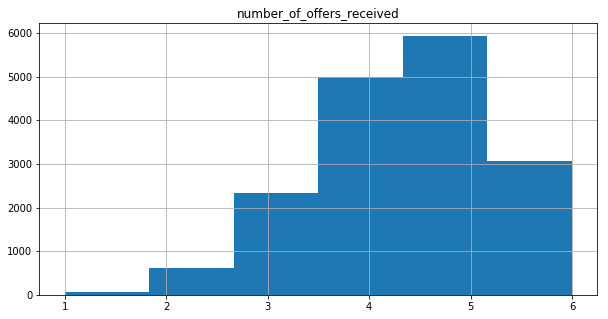

In [14]:
transcript['number_of_offers_received'] = 1
transcript.loc[transcript['event'] == 'offer received'].groupby('person').sum().hist('number_of_offers_received', bins = 6, figsize = [10,5])
transcript.drop(columns = ['number_of_offers_received'], inplace = True)

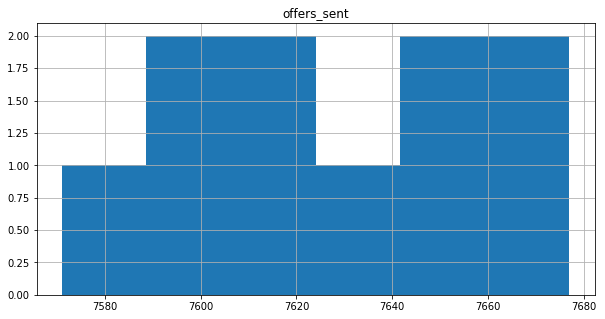

In [15]:
transcript['offers_sent'] = 1
transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer id'] if x.get('offer id') else 'NaN')
transcript.loc[transcript['event'] == 'offer received'].groupby('offer_id').sum().hist('offers_sent', bins = 6, figsize = [10,5])
transcript.drop(columns = ['offer_id', 'offers_sent'], inplace = True)

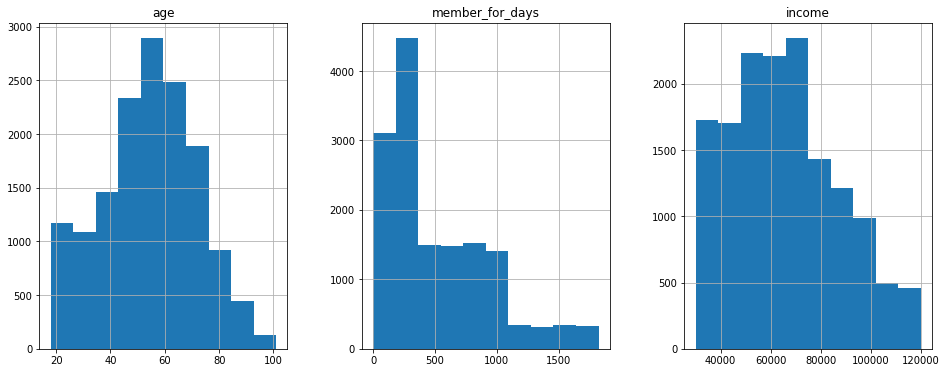

In [16]:
hist = profile.hist(figsize = (16,6), layout = (1,3))

Encoding features of column for single or list like objects

In [17]:
def one_hot_encode(df, column_name):
    value = df[column_name].values[0]
    if hasattr(value, "__iter__") and type(value) is not str:
        all_values = df[column_name].apply(lambda x: tuple(x)).unique()
        unique_values = set([])
        for i in all_values:
            for j in i:
                unique_values.add(j)
        for i in unique_values:
            df[i] = df[column_name].apply(lambda x:1 if i in x else 0)
    else:
        unique_values = df[column_name].unique()
        for i in unique_values:
            df[i] = df[column_name].apply(lambda x:1 if x==i else 0)
            
    df.drop(columns = [column_name], inplace = True)

Encode categorical features

In [18]:
one_hot_encode(portfolio, 'channels')
one_hot_encode(portfolio, 'offer_type')
one_hot_encode(profile, 'gender')

In [19]:
def calculate_responses_and_spending(transcript, portfolio):
    columns = ['offer_id', 'customer_id', 'viewed', 'completed']
    
    #get data about informational offers because special rules apply to them. They don't have a 'offer completed' event
    #so they will be considered completed after the person sees the offer and makes a purchase
    info_df = portfolio.loc[portfolio['informational'] == 1]
    info_ids = info_df['offer_id'].values
    info_duration = info_df['duration_hours'].values
    
    #initializing variables we will need
    response_dict = {} #here we keep number of viewed, completed and received offers for each person
    offer_dict = {} #here we keep whether someone viewed or completed for every offer that was sent
    list = [] #offer_dict will be loaded here, dict was used because of fast lookup time
    spent_dict = {} #amount of money spent for each customer
    
    #looping through the dataframe and processessing the data in a way that we need to loop only once
    for log in transcript.values:    
        person_id = log[1]
        if log[0] == 'offer received':
            offer_id = log[3]['offer id']
            offer_dict[f'{offer_id}_{person_id}'] = [0, 0]
            for i in range(len(info_ids)):
                if offer_id == info_ids[i]:
                    hour_end = info_duration[i] + log[2] 
                    offer_dict[f'{offer_id}_{person_id}'].extend([hour_end+1, hour_end])
            try:
                response_dict[person_id][2] += 1
            except KeyError:
                response_dict[person_id] = [0, 0, 1]
        elif log[0] == 'offer viewed':
            offer_id = log[3]['offer id']
            offer_dict[f'{offer_id}_{person_id}'][0] = 1
            for i in range(len(info_ids)):
                if offer_id == info_ids[i]:
                    offer_dict[f'{offer_id}_{person_id}'][2] = log[2]
            response_dict[person_id][0] += 1
        elif log[0] == 'offer completed':
            offer_id = log[3]['offer_id']
            offer_dict[f'{offer_id}_{person_id}'][1] = 1
            response_dict[person_id][1] += 1
        elif log[0] == 'transaction':
            amount = log[3]['amount']
            try:
                spent_dict[person_id] += amount
            except KeyError:
                spent_dict[person_id] = amount
            for i in info_ids:
                temp_list = offer_dict.get(f'{i}_{person_id}')
                if temp_list and log[2] >= temp_list[2] and log[2] <= temp_list[3]:
                    if temp_list[1] == 0:
                        response_dict[person_id][1] += 1
                    temp_list[1] = 1
                    
        else:
            print(log[0])
            raise Exception('Unknown event')
        
    for k,v in offer_dict.items():

        und_index = k.index('_')
        offer_id = k[:und_index]
        person_id = k[und_index+1:]
        list.append([offer_id, person_id, v[0], v[1]])
    
    #make the resulting dataframe from list
    offer_responses = pd.DataFrame(columns = columns, index = range(len(list)), data = list)
    
    #add extra columns from the dicts
    offer_responses['total_amount'] = offer_responses['customer_id'].apply(lambda x: spent_dict.get(x) if spent_dict.get(x) else 0)
    offer_responses['viewed_rate'] = offer_responses['customer_id'].apply(lambda x: response_dict.get(x)[0]/response_dict.get(x)[2] if response_dict.get(x) else 0)
    offer_responses['completed_rate'] = offer_responses['customer_id'].apply(lambda x: response_dict.get(x)[1]/response_dict.get(x)[2] if response_dict.get(x) else 0)
    return offer_responses

In [20]:
#calculate the response rate per person
def response_rate(df):
    response_dict = {}
    for log in df[['customer_id', 'responded']].values:
        cus_id = log[0]
        response = log[1]
        try:
            response_dict[cus_id][0] += response
        except:
            response_dict[cus_id] = [response, 0]
        response_dict[cus_id][1] += 1
        
    df['response_rate'] = df['customer_id'].apply(lambda x: float(response_dict[x][0]) / response_dict[x][1])
    return df

In [21]:
response_df = calculate_responses_and_spending(transcript, portfolio)
response_df['responded'] = response_df.apply(lambda x: int(x['completed'] == 1 and x['viewed'] == 1), axis = 1)
response_df = response_rate(response_df)

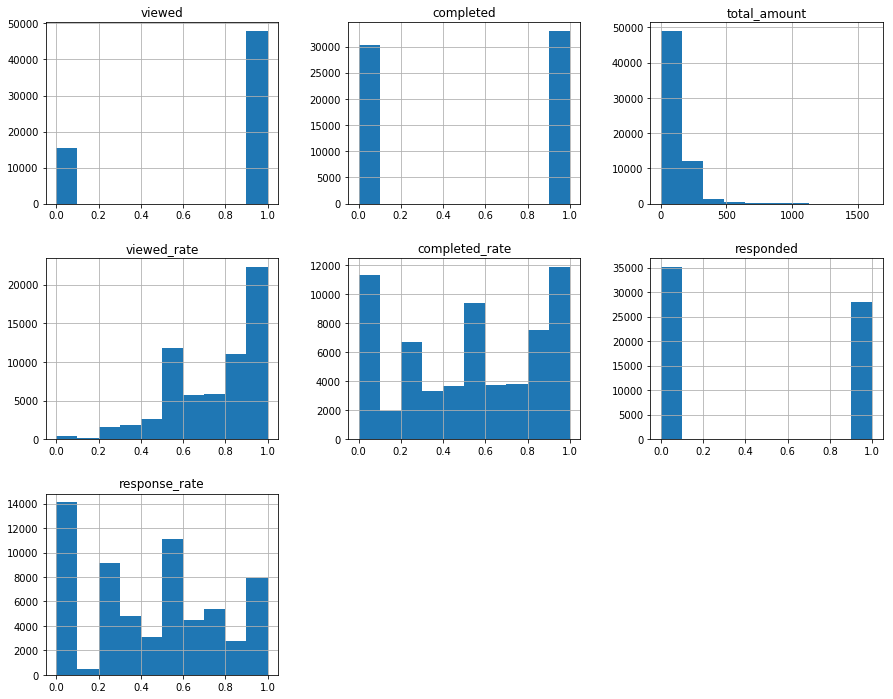

In [22]:
_ = response_df.hist(figsize = (15, 12))


Showing some statistics about the offers

In [23]:
response_df.describe()

,viewed,completed,total_amount,viewed_rate,completed_rate,responded,response_rate
count,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000
mean,0.756320,0.520557,106.434725,0.758087,0.518533,0.443686,0.443686
std,0.429305,0.499581,127.616131,0.229101,0.349808,0.496823,0.331095
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,22.280000,0.600000,0.200000,0.000000,0.200000
50%,1.000000,1.000000,70.780000,0.800000,0.500000,0.000000,0.400000
75%,1.000000,1.000000,151.670000,1.000000,0.800000,1.000000,0.750000
max,1.000000,1.000000,1608.690000,1.000000,1.000000,1.000000,1.000000


In [24]:
merged_df = profile.merge(response_df, on = ['customer_id']).merge(portfolio, on = ['offer_id'])
merged_df.head()

,age,customer_id,member_for_days,income,F,M,O,offer_id,viewed,completed,...,reward,difficulty,duration_hours,mobile,email,web,social,bogo,informational,discount
0,55,0610b486422d4921ae7d2bf64640c50b,376,112000.0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,...,5,5,168,1,1,1,0,1,0,0
1,75,78afa995795e4d85b5d9ceeca43f5fef,443,100000.0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,...,5,5,168,1,1,1,0,1,0,0
2,68,e2127556f4f64592b11af22de27a7932,91,70000.0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,...,5,5,168,1,1,1,0,1,0,0
3,65,389bc3fa690240e798340f5a15918d5c,167,53000.0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,...,5,5,168,1,1,1,0,1,0,0
4,57,6445de3b47274c759400cd68131d91b4,207,42000.0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,...,5,5,168,1,1,1,0,1,0,0


Implementing a function to scale the passed column


In [25]:
def scale_column(df, column_name):
    scaler = MinMaxScaler()
    df[column_name] = scaler.fit_transform(df[column_name].values.reshape(-1, 1))

#scale required columns
scale_column(merged_df, 'income')
scale_column(merged_df, 'age')
scale_column(merged_df, 'difficulty')
scale_column(merged_df, 'reward')
scale_column(merged_df, 'total_amount')
scale_column(merged_df, 'duration_hours')

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [26]:
merged_df.groupby(['offer_id'])[['responded', 'bogo', 'informational', 'discount']].mean().sort_values(by = 'responded')

,responded,bogo,informational,discount
offer_id,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,0.230315,0.0,0.0,1.0
3f207df678b143eea3cee63160fa8bed,0.291455,0.0,1.0,0.0
2906b810c7d4411798c6938adc9daaa5,0.388869,0.0,0.0,1.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,0.393540,1.0,0.0,0.0
ae264e3637204a6fb9bb56bc8210ddfd,0.479871,1.0,0.0,0.0
4d5c57ea9a6940dd891ad53e9dbe8da0,0.488659,1.0,0.0,0.0
5a8bc65990b245e5a138643cd4eb9837,0.502084,0.0,1.0,0.0
f19421c1d4aa40978ebb69ca19b0e20d,0.610652,1.0,0.0,0.0
2298d6c36e964ae4a3e7e9706d1fb8c2,0.713637,0.0,0.0,1.0


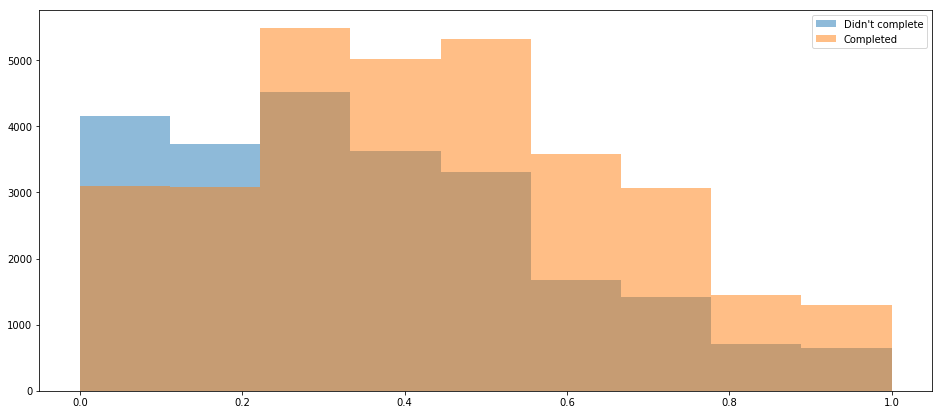

In [27]:
plt.figure(figsize = [16,7])
test_amount_values = merged_df.loc[merged_df['completed'] == 0]['income'].values 
test_2_values = merged_df.loc[merged_df['completed'] == 1]['income'].values
test_hist = plt.hist(test_amount_values, bins = np.linspace(0, 1,10), alpha = 0.5, label = "Didn't complete")
test_2hist = plt.hist(test_2_values, bins = np.linspace(0, 1,10), alpha = 0.5, label = 'Completed')
plt.legend()

<br><br>
Drop columns that we won't need for training

In [28]:
merged_df.drop(columns = ['customer_id', 'offer_id', 'viewed', 'completed'], inplace = True)

Put the label column in the first place

In [29]:
cols = merged_df.columns.tolist()
label_idx = cols.index('responded')
cols = cols[label_idx:label_idx+1] + cols[:label_idx] + cols[label_idx+1:]
merged_df = merged_df[cols]

In [30]:
merged_df.head()

,responded,age,member_for_days,income,F,M,O,total_amount,viewed_rate,completed_rate,...,reward,difficulty,duration_hours,mobile,email,web,social,bogo,informational,discount
0,0,0.445783,376,0.911111,1,0,0,0.047871,0.00,0.500000,...,0.5,0.25,0.571429,1,1,1,0,1,0,0
1,1,0.686747,443,0.777778,1,0,0,0.099006,1.00,1.000000,...,0.5,0.25,0.571429,1,1,1,0,1,0,0
2,1,0.602410,91,0.444444,0,1,0,0.035886,0.75,0.500000,...,0.5,0.25,0.571429,1,1,1,0,1,0,0
3,1,0.566265,167,0.255556,0,1,0,0.022646,1.00,0.833333,...,0.5,0.25,0.571429,1,1,1,0,1,0,0
4,0,0.469880,207,0.133333,0,1,0,0.011873,0.20,0.400000,...,0.5,0.25,0.571429,1,1,1,0,1,0,0


Splitting the data into train and test sets

In [31]:
X = merged_df.values[:, 1:]
y = merged_df.values[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

Fitting the model

In [32]:
logreg = LogisticRegression()

logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)

Calculate the accuracy of the model

In [33]:
accuracy_score(y_test, y_pred)

0.8253402107111502

In [34]:
cat_model = CatBoostClassifier(iterations = 350, learning_rate = 0.126)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)
cat_acc = accuracy_score(y_test, cat_pred)

0:	learn: 0.5703749	total: 74.3ms	remaining: 25.9s
1:	learn: 0.5140370	total: 97.5ms	remaining: 17s
2:	learn: 0.4583820	total: 121ms	remaining: 14s
3:	learn: 0.4316478	total: 142ms	remaining: 12.3s
4:	learn: 0.4125851	total: 165ms	remaining: 11.4s
5:	learn: 0.3880105	total: 189ms	remaining: 10.8s
6:	learn: 0.3779910	total: 212ms	remaining: 10.4s
7:	learn: 0.3683304	total: 235ms	remaining: 10.1s
8:	learn: 0.3587983	total: 257ms	remaining: 9.75s
9:	learn: 0.3510337	total: 284ms	remaining: 9.64s
10:	learn: 0.3430513	total: 306ms	remaining: 9.42s
11:	learn: 0.3379113	total: 330ms	remaining: 9.28s
12:	learn: 0.3345490	total: 354ms	remaining: 9.17s
13:	learn: 0.3317170	total: 376ms	remaining: 9.03s
14:	learn: 0.3281401	total: 399ms	remaining: 8.9s
15:	learn: 0.3251448	total: 423ms	remaining: 8.83s
16:	learn: 0.3226595	total: 445ms	remaining: 8.71s
17:	learn: 0.3205668	total: 468ms	remaining: 8.63s
18:	learn: 0.3186592	total: 494ms	remaining: 8.61s
19:	learn: 0.3170675	total: 518ms	remaining:

In [35]:
cat_acc

0.8531606672519754